In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle
from datetime import datetime
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

General idea: I will try to run everything (different label types, different optimal features) in one nested loop. I will save the performance of the strategy for each case in a list, and then analyze that list.

In [2]:
raw_data = pd.read_pickle(r'../lecture2/dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

I will consider 3 different label types:
1. (-1, 0, +1)
2. (-1, +1)
3. (-2, -1, 0, +1, +2)

In [3]:
def f1(x):
    if x > 0.01:
        return 1
    elif x < -0.01:
        return -1
    else:
        return 0

def f2(x):
    if x > 0:
        return 1
    else:
        return -1

def f3(x):
    absx = abs(x)
    signx = np.sign(x)
    if absx > 0.05:
        return signx*2
    elif absx > 0.01:
        return signx
    else:
        return 0

In [4]:
# adding all three kinds of labels to the data:
data['rel_performance1'] = data['pred_rel_return'].apply(f1)
data['rel_performance2'] = data['pred_rel_return'].apply(f2)
data['rel_performance3'] = data['pred_rel_return'].apply(f3)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [5]:
# as opposed to the lecture material, where we remove 'rel_performance', in this cell,
# I remove the columns ['rel_performance1', 'rel_performance2', 'rel_performance3']
# in the training and test data
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance1', 'rel_performance2', 'rel_performance3', 'pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance1', 'rel_performance2', 'rel_performance3','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In the class, Professor said that it is ok to only try 3 combinations of hyperparameters in HW4, because GridSearch would take too long. However, I decided to try GridSearch with a rather small number of combinations. It does take a long time to run, but not too long.

In [9]:
param_grid = {'n_estimators': [100,200,400], 'reg_lambda': [0.0,0.25,0.5],
   'min_child_samples': [1000,2000,4000], 'max_depth': [2,4,6], 'num_leaves': [15,31]}
# I will use default learning_rate=0.1 everywhere

# Step 1

To find an optimal combination of hyper parameters for the LGBMClassifier for each choice of labels I will do a grid search using 2000--2003 as a training set and 2003-04-01--2003-07-01 as a validation set (using all features):

In [10]:
np.random.seed(123)
optimal_hyper_params = []
# it was necessary to use different objectives for the three label types: 
objectives = ['multi_class', 'binary', 'multi_class']
for label_type_idx in range(1,4):
    # here I choose label type (1, 2, or 3) accroding to label_type_idx values chosen above
    training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
    validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
    
    # gridsearch for best hyperparams:
    train = training_data[0]
    valid = test_data[0]
    combined = pd.concat([train, valid])
    y = np.append(training_labels[0], validation_labels[0])
    indices = np.append(-np.ones(len(train)),np.zeros(len(valid)))
    cv = PredefinedSplit(test_fold=indices)
    gb_clf = lgb.LGBMClassifier(objective=objectives[label_type_idx-1])
    clf = GridSearchCV(gb_clf,
                   param_grid,cv=cv,n_jobs=-1,scoring='accuracy',verbose=3,
                   return_train_score=True)
    clf.fit(combined,y)
    print("-----------------------------------------------------------------")
    print("label_type_idx = ", label_type_idx)
    optimal_hyper_params.append(clf.best_params_)
    print("optimal hyperparameters = ", clf.best_params_)
    print("score = ", clf.best_score_)
    print("-----------------------------------------------------------------")

Fitting 1 folds for each of 162 candidates, totalling 162 fits
-----------------------------------------------------------------
label_type_idx =  1
optimal hyperparameters =  {'max_depth': 2, 'min_child_samples': 4000, 'n_estimators': 100, 'num_leaves': 15, 'reg_lambda': 0.0}
score =  0.5683192261185006
-----------------------------------------------------------------
Fitting 1 folds for each of 162 candidates, totalling 162 fits
-----------------------------------------------------------------
label_type_idx =  2
optimal hyperparameters =  {'max_depth': 2, 'min_child_samples': 4000, 'n_estimators': 100, 'num_leaves': 15, 'reg_lambda': 0.0}
score =  0.6009673518742442
-----------------------------------------------------------------
Fitting 1 folds for each of 162 candidates, totalling 162 fits
-----------------------------------------------------------------
label_type_idx =  3
optimal hyperparameters =  {'max_depth': 2, 'min_child_samples': 4000, 'n_estimators': 100, 'num_leaves': 1

In [12]:
optimal_hyper_params

[{'max_depth': 2,
  'min_child_samples': 4000,
  'n_estimators': 100,
  'num_leaves': 15,
  'reg_lambda': 0.0},
 {'max_depth': 2,
  'min_child_samples': 4000,
  'n_estimators': 100,
  'num_leaves': 15,
  'reg_lambda': 0.0},
 {'max_depth': 2,
  'min_child_samples': 4000,
  'n_estimators': 100,
  'num_leaves': 15,
  'reg_lambda': 0.0}]

### Backtesting all the combinations of optimal features, label types, and the corresponding optimal hyperparameters:

In [14]:
all_results = []
for opt_feat_idx in range(1,4):
    with open(f'Data_for_HW4/gb_opt_feat_{opt_feat_idx}.pkl','rb') as f:
        optimal_features = pickle.load(f)
    for label_type_idx in range(1,4):
        # here I choose label type (1,2, or 3) accroding to label_type_idx values chosen above
        print("Working on gb_opt_feat_idx = ", opt_feat_idx, ", label_type_idx = ", label_type_idx)
        training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
        validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
        hyper_params = optimal_hyper_params[label_type_idx-1]
        results = {"label_type_idx": label_type_idx, "opt_feat_idx": opt_feat_idx,
                   "opt_feat_file": f"gb_opt_feat_{opt_feat_idx}.pkl",
                   "hyper_params": hyper_params}
        gb_clf = lgb.LGBMClassifier(objective=objectives[label_type_idx-1],
                                    n_jobs=-1, **hyper_params)
        P_L = []
        x = [0,1]
        ret = []
        for i in range(1,len(optimal_features)-1):
                gb_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
                pred_i = gb_clf.predict(test_data[i][optimal_features[i-1]])
                profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
                positions = np.sum(np.abs(pred_i))
                x.append(x[i] + (x[i]/positions) * profit_i)
        results['x'] = x
        all_results.append(results)

Working on gb_opt_feat_idx =  1 , label_type_idx =  1
Working on gb_opt_feat_idx =  1 , label_type_idx =  2
Working on gb_opt_feat_idx =  1 , label_type_idx =  3
Working on gb_opt_feat_idx =  2 , label_type_idx =  1
Working on gb_opt_feat_idx =  2 , label_type_idx =  2
Working on gb_opt_feat_idx =  2 , label_type_idx =  3
Working on gb_opt_feat_idx =  3 , label_type_idx =  1
Working on gb_opt_feat_idx =  3 , label_type_idx =  2
Working on gb_opt_feat_idx =  3 , label_type_idx =  3


In [15]:
len(all_results)

9

### Calculating the performance of all the considered strategies and saving the results in the list ```all_results```:

In [48]:
SPY0 = pd.read_pickle(r'../lecture2/SPY_cum_ret.pkl')
def performance_from_x(x, results):
    SPY = SPY0.copy()
    SPY = SPY.loc['2003-10-01':]
    SPY = SPY.resample('Q').ffill()
    SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
    SPY['strategy'] = x[1:]
    results['quarterly_data'] = SPY.copy()
    SPY = SPY.resample('A').bfill()
    results['annual_data'] = SPY.copy()
    strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
    strategy_std = (SPY['strategy'] - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    results['Strategy Sharpe Ratio'] = strategy_sr
    results['SP Sharpe Ratio'] = (SPY['spy_cum_ret'] - 1).diff().mean()/(SPY['spy_cum_ret'] - 1).diff().std()
    results['Strategy total return'] = x[-1]
    results['SPY total return'] = SPY['spy_cum_ret'][-1]
    avr = np.exp(np.log(x[-1])/15.) - 1
    results['Average annual return'] = avr
    sp_avr = np.exp(np.log(SPY['spy_cum_ret'][-1])/15) - 1
    results['SPY average annual return'] = sp_avr
    strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
    spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
    beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
    results['beta'] = beta
    residual_ret = strategy_ret - beta * spy_ret
    IR = np.mean(residual_ret)/np.std(residual_ret)
    results['Information Ratio'] = IR
    alpha = np.mean(residual_ret)
    results['Strategy alpha'] = alpha
for results in all_results:
    performance_from_x(results['x'], results)

An example of a saved dictionary, representing the performace of one of the considered strategies:

In [49]:
all_results[0]

{'label_type_idx': 1,
 'opt_feat_idx': 1,
 'opt_feat_file': 'gb_opt_feat_1.pkl',
 'hyper_params': {'max_depth': 2,
  'min_child_samples': 4000,
  'n_estimators': 100,
  'num_leaves': 15,
  'reg_lambda': 0.0},
 'x': [0,
  1,
  1.1047145721649485,
  1.2257503912392116,
  1.217668350318649,
  1.1901856220393228,
  1.2902336796503364,
  1.392024981460798,
  1.3717645398374083,
  1.5132676698240382,
  1.4877238851913084,
  1.6350778339266823,
  1.7227999984506466,
  1.6369875548697872,
  1.778416689531961,
  1.907522718153548,
  2.015193584682987,
  1.9800259306364572,
  2.018037767247838,
  1.9098791107224076,
  1.9801177548807354,
  1.8536028186738776,
  1.4881545861773973,
  1.525837635463847,
  1.6554228346540751,
  1.7592989363404476,
  1.9433666067248494,
  2.0717807959344237,
  2.217011912574536,
  2.142318484224781,
  2.3619323479322767,
  2.6419044606979813,
  2.751984612206112,
  2.5007288941698285,
  2.5211826165788898,
  2.7683064260888415,
  2.772508028152527,
  2.7590484287170

### Creating a function to find max yearly drawdown

<AxesSubplot:xlabel='date'>

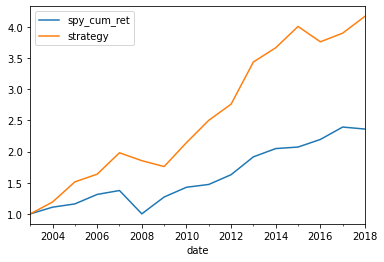

In [18]:
# let's use first combination of parameters as an example
all_results[0]['annual_data'].plot()

I will make my own function for max drawdown calculation, it calculates the same thing as the one Professor showed us in class, but in a different way.

I use the fact that in the region between a local max and the **next** local min, the slope of the curve is negative, by definition. Thus, I find the regions (start_index, end_index) where the slope is negative. Then, a drawdown is just the drop in each such region. The only difference that I introduce compared to the lecture is that I divide the absolute drop by the value of the curve at the beginning of the drop. I think a relative drop is more relevant to characterize how anxious investors are.

In [19]:
# this cell finds index ranges of return drops
ys = all_results[0]['annual_data']['strategy']
diff = ys.diff().fillna(0)
drawdown_indexes = [] # list of tuples (start_of_drop, end_of_drop)
i = 0
while i < len(ys):
    if diff[i] < 0: # find the beginning of drop
        start_idx = i-1
        while i < len(ys) and diff[i] < 0: # go on until the end of the drop
            i += 1
        end_idx = i-1
        drawdown_indexes.append((start_idx, end_idx))
    else:
        i += 1
drawdown_indexes

[(4, 6), (12, 13)]

In [20]:
drawdowns = [(ys[start_idx]-ys[end_idx])/ys[start_idx] for start_idx, end_idx in drawdown_indexes]
drawdowns

[0.1114768200157153, 0.061415524896837194]

In [21]:
# The above calculation of drawdown seems to work. Let us define it as a funciton:
def get_max_drawdown(ys):
    diff = ys.diff().fillna(0)
    drawdown_indexes = [] # list of tuples (start_of_drop, end_of_drop)
    i = 0
    while i < len(ys):
        if diff[i] < 0: # find the beginning of drop
            start_idx = i-1
            while i < len(ys) and diff[i] < 0: # go on until the end of the drop
                i += 1
            end_idx = i-1
            drawdown_indexes.append((start_idx, end_idx))
        else:
            i += 1
    drawdowns = [(ys[start_idx]-ys[end_idx])/ys[start_idx] for start_idx, end_idx in drawdown_indexes]
    max_drawdown = max(drawdowns) if len(drawdowns) else 0 # no drawdowns is a possibility
    return max_drawdown

In [22]:
# calculate max drawdown for all strategies:
for res in all_results:
    res['max_drawdown'] = get_max_drawdown(res['annual_data']['strategy'])

In [23]:
# auxiliary function to print performance of a given strategy
def print_strategy_performance(res):
    print("----------------------------------------------------------------------------")
    res['annual_data'].plot()
    plt.show()
    for key, val in res.items():
            if key in ["x", "annual_data", "quarterly_data"]:
                continue
            else:
                print(key, " = ", val)
    print("----------------------------------------------------------------------------")

Strategy with the smallest max_drawdown:
----------------------------------------------------------------------------


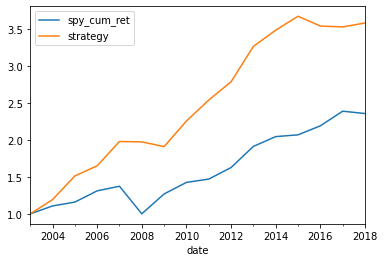

label_type_idx  =  2
opt_feat_idx  =  3
opt_feat_file  =  gb_opt_feat_3.pkl
hyper_params  =  {'max_depth': 2, 'min_child_samples': 4000, 'n_estimators': 100, 'num_leaves': 15, 'reg_lambda': 0.0}
Strategy Sharpe Ratio  =  0.9921295053837347
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.5871828798995566
SPY total return  =  2.360200999999999
Average annual return  =  0.08888889297056557
SPY average annual return  =  0.058920280465017294
beta  =  0.27363542663834534
Information Ratio  =  0.9028402759029404
Strategy alpha  =  0.14766557993004353
max_drawdown  =  0.039287997424836255
----------------------------------------------------------------------------


In [24]:
# find the smallest max drawdown among all strategies:
all_drawdowns = np.array([res['max_drawdown'] for res in all_results])
min_idx = np.argmin(all_drawdowns)
opt_res = all_results[min_idx]
print("Strategy with the smallest max_drawdown:")
print_strategy_performance(opt_res)

In this case the strategy with the smallest drawdown has a Sharpe Ratio = 0.99 < 1. Let's see if we can find another strategy with Sharpe Ratio > 1, and a low max drawdown:

In [26]:
good_sharpe_ratio_results = [res for res in all_results if res['Strategy Sharpe Ratio'] > 1]
len(good_sharpe_ratio_results)

5

In [27]:
[(res['Strategy Sharpe Ratio'], res['max_drawdown']) for res in good_sharpe_ratio_results]

[(1.0154592526718336, 0.058607087160490436),
 (1.0409787182899195, 0.046073362099976416),
 (1.0211124870385409, 0.05288889087005675),
 (1.0609854476664082, 0.06824235670643698),
 (1.0617687408041432, 0.06537493746089303)]

----------------------------------------------------------------------------


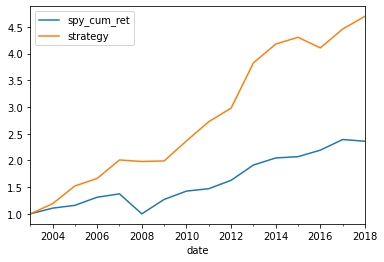

label_type_idx  =  2
opt_feat_idx  =  2
opt_feat_file  =  gb_opt_feat_2.pkl
hyper_params  =  {'max_depth': 2, 'min_child_samples': 4000, 'n_estimators': 100, 'num_leaves': 15, 'reg_lambda': 0.0}
Strategy Sharpe Ratio  =  1.0409787182899195
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.700309982526714
SPY total return  =  2.360200999999999
Average annual return  =  0.10868566780413302
SPY average annual return  =  0.058920280465017294
beta  =  0.6479341934110251
Information Ratio  =  0.893461438023969
Strategy alpha  =  0.187932616314323
max_drawdown  =  0.046073362099976416
----------------------------------------------------------------------------


In [30]:
# in my opinion the second strategy in the list above has
# the optimal combination of Sharpe Ratio and Max Drawdown
best_strategy_lgb = good_sharpe_ratio_results[1]
print_strategy_performance(best_strategy_lgb)

# Step 2

I will consider a combination of the best LightGB model (from this notebook, Step 1), the best RandomForest model, and the best AdaBoost model (from the AdaBoost_and_RandomForest.ipynb).

When I say "a combination of models", I mean that we invest $x_1$ dollars into model 1, $x_2$ dollars into model 2, etc. But the sum has to be 1, i.e., $x_1$+$x_2$+$\dots$=1

In this approach, if we do not redistribute money among the models in the process, we can calculate the backtest curves independently for each model, and then just take a weighted combinaiton of the curves.

Thus, I could just use the backtest curves for RF and AdaBoost, calculated in AdaBoost_and_RandomForest.ipynb, but I did not save them. Therefore, I will have to recalculate them below (with the optimal label types, hyperparameters, and features, found in AdaBoost_and_RandomForest.ipynb).

In [41]:
# Best LGBM from this HW Problem 1:
gb_label_type_idx = best_strategy_lgb['label_type_idx']
gb_opt_feat_file = best_strategy_lgb['opt_feat_file']
gb_clf = lgb.LGBMClassifier(objective=objectives[gb_label_type_idx-1],
                                    n_jobs=-1, **best_strategy_lgb['hyper_params'])

In [42]:
# Best RandomForest model from HW3 Problem 1:
rf_label_type_idx  =  1
rf_opt_feat_file  =  'opt_feat_6.pkl'
rf_hyper_params  =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000,
                     'n_estimators': 15}

In [46]:
# recalculating the backtest curve for RF:
with open(f'../lecture5/opt_feature_files/{rf_opt_feat_file}','rb') as f:
        optimal_features = pickle.load(f)
label_type_idx = rf_label_type_idx
print("Working on opt_feat_idx = ", opt_feat_idx, ", label_type_idx = ", label_type_idx)
training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
hyper_params = rf_hyper_params
rf_results = {"label_type_idx": label_type_idx, "opt_feat_idx": opt_feat_idx,
           "opt_feat_file": f"opt_feat_{opt_feat_idx}.pkl",
           "hyper_params": hyper_params}
rf_clf = RandomForestClassifier(bootstrap=True, n_jobs=-1, **hyper_params)
P_L = []
x = [0,1]
ret = []
for i in range(1,len(optimal_features)-1):
        rf_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = rf_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        positions = np.sum(np.abs(pred_i))
        x.append(x[i] + (x[i]/positions) * profit_i)
rf_results['x'] = x

Working on opt_feat_idx =  3 , label_type_idx =  1


In [44]:
# Best AdaBoost model from HW3 Problem 2:
ab_label_type_idx  =  2
ab_opt_feat_file  =  'ada_opt_feat_3.pkl'
ab_hyper_params  =  {'learning_rate': 0.1, 'n_estimators': 35}

In [47]:
# recalculating the backtest curve for AdaBoost
with open(f'../lecture5/opt_feature_files/{ab_opt_feat_file}','rb') as f:
        optimal_features = pickle.load(f)
label_type_idx = ab_label_type_idx
print("Working on opt_feat_idx = ", opt_feat_idx, ", label_type_idx = ", label_type_idx)
training_labels = [d[f'rel_performance{label_type_idx}'].values for d in training_frames]
validation_labels = [d[f'rel_performance{label_type_idx}'].values for d in test_frames]
hyper_params = ab_hyper_params
ab_results = {"label_type_idx": label_type_idx, "opt_feat_idx": opt_feat_idx,
           "opt_feat_file": f"ada_opt_feat_{opt_feat_idx}.pkl",
           "hyper_params": hyper_params}
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME.R", **hyper_params)
P_L = []
x = [0,1]
ret = []
for i in range(1,len(optimal_features)-1):
        ada_clf.fit(training_data[i][optimal_features[i-1]],training_labels[i])
        pred_i = ada_clf.predict(test_data[i][optimal_features[i-1]])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        positions = np.sum(np.abs(pred_i))
        x.append(x[i] + (x[i]/positions) * profit_i)
ab_results['x'] = x

Working on opt_feat_idx =  3 , label_type_idx =  2


In [53]:
# recalculating the performance parameters for the RF and AdaBoost models from HW3:
for results in [rf_results, ab_results]:
    performance_from_x(results['x'], results)
for res in [rf_results, ab_results]:
    res['max_drawdown'] = get_max_drawdown(res['annual_data']['strategy'])

----------------------------------------------------------------------------


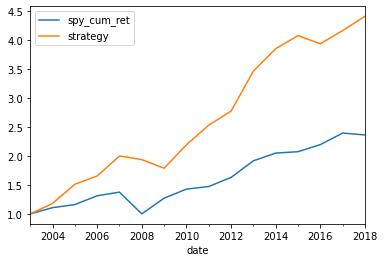

label_type_idx  =  1
opt_feat_idx  =  3
opt_feat_file  =  opt_feat_3.pkl
hyper_params  =  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1000, 'n_estimators': 15}
Strategy Sharpe Ratio  =  1.0330717293116027
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.404125324540931
SPY total return  =  2.360200999999999
Average annual return  =  0.10388537083168847
SPY average annual return  =  0.058920280465017294
beta  =  0.46121809615534093
Information Ratio  =  0.9153423004594956
Strategy alpha  =  0.18511840059548934
max_drawdown  =  0.10543808166325794
----------------------------------------------------------------------------


In [57]:
# Random Forest strategy
print_strategy_performance(rf_results)
# the results may be a little bit different from HW3 because I didn't set random_state 

----------------------------------------------------------------------------


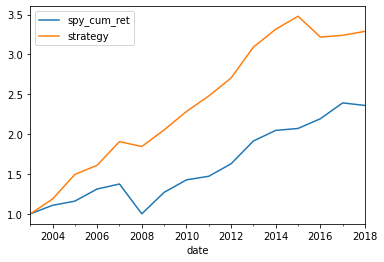

label_type_idx  =  2
opt_feat_idx  =  3
opt_feat_file  =  ada_opt_feat_3.pkl
hyper_params  =  {'learning_rate': 0.1, 'n_estimators': 35}
Strategy Sharpe Ratio  =  0.9405593192872512
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.2900600880896236
SPY total return  =  2.360200999999999
Average annual return  =  0.08263049350085261
SPY average annual return  =  0.058920280465017294
beta  =  0.44422535915054817
Information Ratio  =  0.7801995664249727
Strategy alpha  =  0.1123882873565126
max_drawdown  =  0.07499325897578986
----------------------------------------------------------------------------


In [58]:
# AdaBoost strategy
print_strategy_performance(ab_results)
# the results are a little bit different from HW3 because I didn't set random_state

### Finally, now we can combine the three models:

----------------------------------------------------------------------------


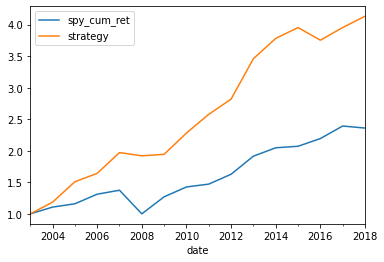

strategy 1  =  LightGB
strategy 2  =  RandomForest
strategy 3  =  AdaBoost
weights  =  [0.3333333333333333, 0.3333333333333333, 0.3333333333333334]
Strategy Sharpe Ratio  =  1.0737249656183983
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.131498465052423
SPY total return  =  2.360200999999999
Average annual return  =  0.09919271074141833
SPY average annual return  =  0.058920280465017294
beta  =  0.5177925495723044
Information Ratio  =  0.9332040992029434
Strategy alpha  =  0.16181310142210842
max_drawdown  =  0.05053145057677004
----------------------------------------------------------------------------
----------------------------------------------------------------------------


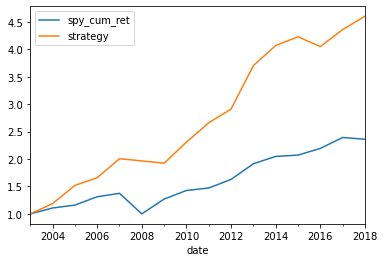

strategy 1  =  LightGB
strategy 2  =  RandomForest
strategy 3  =  AdaBoost
weights  =  [0.6666666666666666, 0.3333333333333333, 5.551115123125783e-17]
Strategy Sharpe Ratio  =  1.0498270618336782
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.601581763198119
SPY total return  =  2.360200999999999
Average annual return  =  0.10711773940497582
SPY average annual return  =  0.058920280465017294
beta  =  0.5856954943257969
Information Ratio  =  0.9108695564704864
Strategy alpha  =  0.1869945444080451
max_drawdown  =  0.04230721491875286
----------------------------------------------------------------------------
----------------------------------------------------------------------------


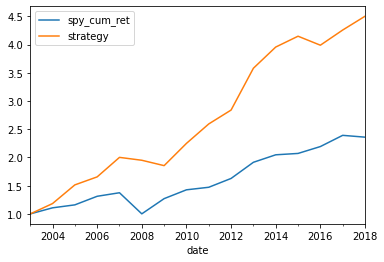

strategy 1  =  LightGB
strategy 2  =  RandomForest
strategy 3  =  AdaBoost
weights  =  [0.3333333333333333, 0.6666666666666666, 1.1102230246251565e-16]
Strategy Sharpe Ratio  =  1.0477628580270117
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  4.5028535438695245
SPY total return  =  2.360200999999999
Average annual return  =  0.1055180932722466
SPY average annual return  =  0.058920280465017294
beta  =  0.5234567952405689
Information Ratio  =  0.9185245770629852
Strategy alpha  =  0.18605647250176718
max_drawdown  =  0.07317006383009919
----------------------------------------------------------------------------
----------------------------------------------------------------------------


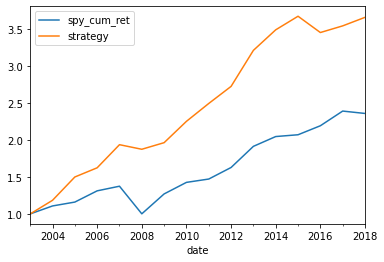

strategy 1  =  LightGB
strategy 2  =  RandomForest
strategy 3  =  AdaBoost
weights  =  [0, 0.3333333333333333, 0.6666666666666667]
Strategy Sharpe Ratio  =  1.0481223306399305
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.661415166906726
SPY total return  =  2.360200999999999
Average annual return  =  0.090376789941921
SPY average annual return  =  0.058920280465017294
beta  =  0.44988960481881207
Information Ratio  =  0.9047289375150346
Strategy alpha  =  0.13663165843617156
max_drawdown  =  0.05998895727888341
----------------------------------------------------------------------------
----------------------------------------------------------------------------


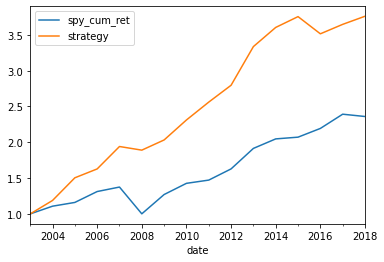

strategy 1  =  LightGB
strategy 2  =  RandomForest
strategy 3  =  AdaBoost
weights  =  [0.3333333333333333, 0, 0.6666666666666667]
Strategy Sharpe Ratio  =  1.0463259921317278
SP Sharpe Ratio  =  0.5846194645603067
Strategy total return  =  3.7601433862353204
SPY total return  =  2.360200999999999
Average annual return  =  0.092312642957872
SPY average annual return  =  0.058920280465017294
beta  =  0.5121283039040403
Information Ratio  =  0.8924515538343573
Strategy alpha  =  0.1375697303424494
max_drawdown  =  0.06393797973512057
----------------------------------------------------------------------------


In [68]:
# Since weights must add up to 1, we only need to specify two weights w1 and w2.
# Up to two out of the three weights can even be negative (shorting).
# Anyways, I will consider the following combinations of w1 and w2:
w1w2_list = [
    (1/3, 1/3), (2/3, 1/3), (1/3, 2/3), (0, 1/3), (1/3, 0)
] 
for w1,w2 in w1w2_list:
    w3 = 1-w1-w2
    weights = [w1,w2,w3]
    res_combined = {"strategy 1": "LightGB", "strategy 2": "RandomForest", "strategy 3": "AdaBoost",
           "weights": weights}
    x1 = np.array(best_strategy_lgb['x'])
    x2 = np.array(rf_results['x'])
    x3 = np.array(ab_results['x'])

    x = w1*x1 + w2*x2 + w3*x3
    performance_from_x(x, res_combined)
    res_combined['max_drawdown'] = get_max_drawdown(res_combined['annual_data']['strategy'])
    print_strategy_performance(res_combined)

In my opinion, the first two strategies in the above cell have the best combinations of Sharpe Ratio and Max Drawdown, compared to the rest of considered combinations of weights.